# Do variants detected within-host ever emerge downstream in transmission chains? 

This notebook contains code to query within-host variants for whether they ever rise to consensus in downstream portions of the phylogenetic tree. 

In [90]:
import imp
import importlib, json
import glob
import re,copy,json
import Bio.Phylo
import requests
import pandas as pd 
import numpy as np

# for this to work, you will need to download the most recent version of baltic, available here 
bt = imp.load_source('baltic', '../baltic/baltic.py')

import copy
from scipy.special import binom
import datetime as dt

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.colors as clr
import textwrap as textwrap
from textwrap import wrap

from IPython.display import HTML


try:
    from StringIO import StringIO as sio
    from cStringIO import StringIO as csio
except ImportError:
    from io import StringIO as sio
    from io import BytesIO as csio
    
    
import rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [3]:
# define which column we want to use to look at variants. Use 'nuc_muts' to characterize variants relative to the 
# Wuhan 1 reference, or 'minor_nuc_muts' to do a consensus-agnostic comparison
variant_column = 'minor_nuc_muts'
frequency_column = 'minor_frequency'

## Read in vcfs and convert to dataframes 

I will only read in the intersection SNVs, meaning the ones that were detected in both technical sequencing replicates. This code will separate this into 2 dataframes, 1 for SNVs and 1 for indels, and will also look up and add in the strain names (necessary for converting from tube numbers, which is how the csvs are labelled). All of this code is contained in the ipython notebook called `vcf-module.ipynb`, which I am just going to import here. By running `return_dataframes`, this will collate all vcfs in the vcf directory, combine into a dataframe, and format that dataframe properly. 

In [4]:
"""to load in an ipython notebook as a module, just run the following. You will now have access to all of the 
functions written in that jupyter notebook"""

%run vcf-module.ipynb

In [5]:
# read in the current date 
from datetime import date
today = date.today()
current_date = str(today.strftime("%Y-%m-%d"))

In [6]:
"""now, input the strain names file/metadata file, the directory containing the vcfs, and return the dataframess"""

strain_names_file = "/Users/lmoncla/src/ncov-WI-within-host/data/sample-metadata.tsv"
fasta_file = "../data/consensus-sequences-2021-01-25.fasta"
clades_file = "../data/clades-file-2020-08-28.txt"
vcf_directory = "../data/vcfs-all/"

# N transcript was a control; sample/tube 6, UW-30, has an snv at basically every single site after a certain 
# point in the genome. it has 418 SNVs!!! I'm excluding it; finally, I am going to exclude tube 127, USA/WI-UW-118/2020
# which has >50 indels and >50 SNVs. It has a pretty high Ct as well, so I think these are probably errors as it is 
# a very clear outlier
samples_to_ignore = ["N_transcript","6", "127"]

# set the length of homopolymers that you want to use
homopolymer_length = 3

# set the variant percent that you want to use 
variant_percent = "0.03"

snvs_only, indels_only, all_intersection_variants,metadata_dict = return_dataframes(strain_names_file, clades_file,vcf_directory,samples_to_ignore,fasta_file, homopolymer_length)

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [7]:
"""subset data to include only SNVs and indels >3% frequency"""
snvs_only = snvs_only[snvs_only[frequency_column] >= float(variant_percent)]
indels_only = indels_only[indels_only[frequency_column] >= float(variant_percent)]

"""subset data to include only SNVs and indels <50% frequency"""
snvs_only = snvs_only[snvs_only[frequency_column] <= float(0.5)]
indels_only = indels_only[indels_only[frequency_column] <= float(0.5)]

In [8]:
all_intersection_variants.head()

,Unnamed: 0,SNP,POS_x,rep1_percent,rep2_percent,frequency,sampleid,gene,nt_change,aa_change,annotation,strain_name,location,clade,homopolymer,homopolymer_base,type_of_variant
0,0,orf1ab_-delTCATGTTATGGTTG_His83fs_frameshift,509.0,0.0326,0.0114,0.02200,53,orf1ab,-delTCATGTTATGGTTG,His83fs,frameshift,USA/WI-UW-67/2020,Dane County,19B,not,[],indel
1,1,orf1ab_dupA_Leu293fs_frameshift,1135.0,0.0161,0.0122,0.01415,53,orf1ab,dupA,Leu293fs,frameshift,USA/WI-UW-67/2020,Dane County,19B,not,[],indel
2,6,orf1ab_dupT_Leu2146fs_frameshift,6696.0,0.0335,0.0968,0.06515,53,orf1ab,dupT,Leu2146fs,frameshift,USA/WI-UW-67/2020,Dane County,19B,in,a,indel
3,8,orf1ab_C>T_Ser2839Ser_synonymous,8782.0,0.9411,0.8919,0.91650,53,orf1ab,C>T,Ser2839Ser,synonymous,USA/WI-UW-67/2020,Dane County,19B,not,[],snv
4,11,orf1ab_dupA_Pro3851fs_frameshift,11812.0,0.0150,0.0108,0.01290,53,orf1ab,dupA,Pro3851fs,frameshift,USA/WI-UW-67/2020,Dane County,19B,not,[],indel


In [9]:
print(len(all_intersection_variants))

2266


In [10]:
snvs_to_query = set(snvs_only[variant_column])
indels_to_query = set(indels_only[variant_column])
all_variants_to_query = snvs_to_query.copy()
all_variants_to_query.update(indels_to_query)
print(len(snvs_to_query))
print(len(indels_to_query))
print(len(all_variants_to_query))

229
25
254


## A small function to order the SNVs by site

In [11]:
"""given a list of SNVs, sort them by their site number to make the resuling plot easier to read and look at"""

def sort_mutations(muts):
    muts_dict = {}
    sites_list = []
    final_order = []
    
    for m in muts:
        site = int(m[1:-1])
        
        if site not in muts_dict:
            muts_dict[site] = []
            
        muts_dict[site].append(m)
        sites_list.append(site)
    
    sites_list = list(set(sites_list))
    sites_list.sort()
    
    for s in sites_list:
        for x in muts_dict[s]:
            final_order.append(x)
    
    return(final_order)

## Do within-host variants appear downstream of the sample they were taken from?



In [28]:
"""using baltic's subtree function, enumerate the subtree descending from the supplied node"""

def return_subtree(node, tree):
    subtree=tree.subtree(node) ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state
            
    if subtree != None:
        subtree.traverse_tree()
        subtree.sortBranches()
        return(subtree)

In [12]:
def return_within_host_muts_for_branch(branch, df):
    d = df[df['strain_name'] == branch.name]
    within_host_muts = d['nuc_muts'].to_list()
    return(within_host_muts)

In [13]:
def return_within_host_muts_for_tip_name(tip_name, df):
    d = df[df['strain_name'] == tip_name]
    within_host_muts = d['nuc_muts'].to_list()
    return(within_host_muts)

In [14]:
def return_proper_parent_node(node):
    """given an internal node, traverse back up the tree to find a parental node with a 
    real branch length (basically, collapse the polytomy). This is necessary for most 
    tree software, including iqtree and treetime, which both normally atempt to resolve
    polytomies, resulting in a fully bifurcating tree with lots of very tiny branches"""
    
    #print(node, node.length)
    if abs(node.traits['node_attrs']['div'] - node.parent.traits['node_attrs']['div']) < 0.0000000001: 
        
        #print("going up 1 node")
        if node.parent !=None:
            parent_node = return_proper_parent_node(node.parent)
        
        else:
            #print("root is proper parent")
            parent_node = node
    
    else: 
        #print("current node has proper length")
        parent_node = node
    
    return(parent_node)

In [15]:
def return_nt_muts_on_branch(branch):
    nt_muts = []
    if 'branch_attrs' in branch.traits:
        if 'mutations' in branch.traits['branch_attrs']:
            if 'nuc' in branch.traits['branch_attrs']['mutations']:
                nt_muts = branch.traits['branch_attrs']['mutations']['nuc']
                            
    return(nt_muts)

In [16]:
"""Given a starting internal node, and a tip you would like to end at, traverse the full path from that node to
tip. Along the way, gather nucleotide mutations that occur along that path. Once you have reached the ending 
tip, return the list of mutations that fell along that path"""

def return_all_muts_on_path_to_tip(starting_node, ending_tip):
    
    # set an empty list of mutations and enumerate the children of the starting node; children can be tips or nodes
    muts = []
    children = starting_node.children
    
    for child in children:
        nt_muts = []
        
        """if the child is a leaf: if leaf is the target end tip, add the mutations that occur on that branch to the list
        and return the list; if leaf is not the target end tip, move on"""
        """if the child is an internal node: first, test whether that child node contains the target tips in its 
        children. child.leaves will output a list of the names of all tips descending from that node. If not, pass. 
        if the node does contain the target end tip in its leaves, keep traversing down that node recursively, 
        collecting mutations as you go"""

        if child.branchType == "leaf":
            if child.name != ending_tip:
                pass
            elif child.name == ending_tip:
                nt_muts = return_nt_muts_on_branch(child)
                for n in nt_muts:
                    muts.append(n)
                return(muts)
        
        
        elif child.branchType == "node":
            if ending_tip not in child.leaves:
                pass
            else:
                nt_muts = return_nt_muts_on_branch(child)
                for n in nt_muts:
                    muts.append(nt_muts)
                return_all_muts_on_path_to_tip(child, ending_tip)
    
    
    # flatten the list so that you don't have nested lists
    flat_list = [item for sublist in muts for item in sublist]
    return(flat_list)

In [17]:
def run_tree_test(input_tree, df_to_run):
    on_internal_nodes = 0
    on_internal_nodes_with_children = 0
    has_WI_children = {}
    for k in input_tree.Objects: 

        """if the tip is one of the Wisconson sequences for which we have within-host data, pull out its division, 
        divergence value, and the divergence of its parent node"""
        if k.name in strain_names_to_query:
            has_WI_children[k.name] = []

            k_within_host_muts = return_within_host_muts_for_branch(k, df_to_run)

            if 'division' in k.traits['node_attrs']:
                division = k.traits['node_attrs']['division']['value']
                branch_length = k.traits['node_attrs']['div']
                parent_branch_length = k.parent.traits['node_attrs']['div']


                """if you lie on an internal node and are from Wisconsin, find the proper parent (collapsing very small
                branches induced by polytomy resolution) and return all children descending from that parent node"""
                if branch_length - parent_branch_length < 0.000000001:
                    on_internal_nodes += 1
                    #print(k.name, "lies on internal node")
                    #if division == "Wisconsin":
                    proper_parent = return_proper_parent_node(k.parent)
                    child_tips = proper_parent.leaves
                    if len(child_tips) > 0:
                        on_internal_nodes_with_children += 1
                    #print(child_tips, len(child_tips))

                    """next, for child, traverse the path from parent to child, enumerating mutations that fall 
                    along that path"""
                    for c in child_tips:
                        mutations = return_all_muts_on_path_to_tip(proper_parent, c)
                        for m in mutations: 
                            if m in k_within_host_muts:
                                print(k.name, c, m)
                                
                                
                    """finally, for child, if we have within-host data on that child tip, see if any match. The 
                    fuction I'm using here is slightly different, just in that is input a string instead of baltic
                    branch object"""
                    for c in child_tips:
                        if c in strain_names_to_query and c != k.name:
                            has_WI_children[k.name].append(c)
                            child_within_host_muts = return_within_host_muts_for_tip_name(c, df_to_run)
                            for m in child_within_host_muts: 
                                if m in k_within_host_muts: 
                                    #print("within-host mutation shared", k.name, c, m)
                                    pass
    return(on_internal_nodes, on_internal_nodes_with_children, has_WI_children)

In [18]:
# test this out first on the Wisconsin-only build json
WI_tree_path = "../data/auspice-jsons/Wisconsin-SARS-CoV-2_ncov_wisconsin_2021-1-15.json"

with open(WI_tree_path) as json_file:
    WI_tree_json = json.load(json_file)
WI_tree_object=WI_tree_json['tree']
WI_meta=WI_tree_json['meta']
json_translation={'absoluteTime':lambda k: k.traits['node_attrs']['num_date']['value'],'name':'name'} ## allows baltic to find correct attributes in JSON, height and name are required at a minimum
#json_meta={'file':WI_meta,'traitName':analysis_level} ## if you want auspice stylings you can import the meta file used on nextstrain.org

WI_tree=bt.loadJSON(WI_tree_object,json_translation)


Tree height: 1.077257
Tree length: 322.284653
multitype tree
annotations present

Numbers of objects in tree: 8894 (4127 nodes and 4767 leaves)



In [19]:
strain_names_to_query = list(set(all_intersection_variants['strain_name']))
#print(strain_names_to_query)
print(len(strain_names_to_query))

141


In [20]:
df_to_run = snvs_only
tree_to_use = WI_tree

on_internal_nodes, on_internal_nodes_with_children, tips_with_WI_descendants = run_tree_test(tree_to_use, df_to_run)

USA/WI-UW-214/2020 USA/WI-WSLH-200068/2020 C1912T


In [21]:
print(on_internal_nodes, on_internal_nodes_with_children, len(strain_names_to_query))

120 120 141


So, out of 143 tips, 120 were on internal nodes. Of those, only 1 had downstream tips with a fixed variant. USA/WI-UW-214/2020 is part of a largeish polytomy and the child tip has 2 mutations different, 1 is the within-host variant, and the other is a different variant. 

## Plot a tree snippet showing this transmission event

In [75]:
for k in WI_tree.Objects: 
    if k.name == "USA/WI-UW-214/2020":
        parental_node = return_proper_parent_node(k)
        print(parental_node)
        subtree = return_subtree(parental_node, WI_tree)
        print(subtree)

In [81]:
mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rc('text', usetex='false') 
mpl.rcParams.update({'font.size': 10})

In [82]:
tip_color = "#5248AA"
background_color = "#9DB4C1"
tips_to_color = ["USA/WI-UW-214/2020","USA/WI-WSLH-200068/2020"]
#7C9BAC
#ECC58C
#551E32
#434A42
#9E6240
#B4656F

In [83]:
filename = "../figures/individual-pdfs/tree-transmission-example-2020-02-04.pdf"

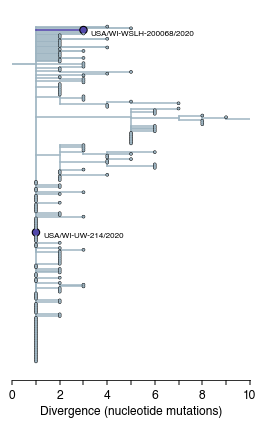

In [89]:
fig,ax = plt.subplots(figsize=(4,6),facecolor='w')

# # this sets the vertical dashed lines on the tree; plot a dashed line every other year from 1990 to 2020
x_ls = []
for i in range(0,11):
    x_ls.append(i)  

# # # set date labels to be every other
x_labels = []
for x in x_ls[::2]:
    x_labels.append(str(x))
    x_labels.append("")

branchWidth=1.5 ## default branch width
tipSize = 40

# k objects are tips, nodes, branches
for k in subtree.Objects: ## iterate over objects in tree
    x=k.traits['node_attrs']['div']  # plot divergence instead of time; replace with k.absoluteTime for time tree
    y=k.y 

    if 'node_attrs' in k.parent.traits:
        xp=k.parent.traits['node_attrs']['div'] ## get x position of current object's parent
    else:
        xp=0.0
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x

    if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
        if k.name in tips_to_color:
            s=tipSize
            z=12
            label = k.name
        else:
            s=tipSize/6
            z=11
            label = ''

        if k.name in tips_to_color:
            c=tip_color
        else: 
            c=background_color

        ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=z) ## plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
        ax.text(x+0.3,y-3,label, fontsize=8,zorder=13)

    elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
        number_children = len(k.leaves)
        node_branchwidth = branchWidth + number_children*0.001
        c=background_color
        ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=node_branchwidth,color=c,ls='-',zorder=9) #color=node_colors[node_types[k]["node_community_status"]]

    ax.plot([xp,x],[y,y],lw=node_branchwidth,color=c,ls='-',zorder=9)
        

# set axis limits, remove border lines         
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

#ax.set_ylim(-5,tree.ySpan+5)
ax.set_xlim(0,10)
ax.tick_params(axis='y',labelsize=0,size=0)
ax.tick_params(axis='x',labelsize=12,size=5, width=2,color='grey')
ax.set_xticks(x_ls)
ax.set_xlabel("Divergence (nucleotide mutations)", fontsize=12)
ax.set_xticklabels(x_labels, fontsize=12)   # set date labels every 4
ax.set_yticklabels([])

fig.tight_layout()
plt.gcf().subplots_adjust(right=0.88)
plt.savefig(filename)

plt.show()